# Relevant Segment Extraction (RSE)

## Overview

Relevant segment extraction (RSE) is a method of reconstructing multi-chunk segments of contiguous text out of retrieved chunks. This step occurs after vector search (and optionally reranking), but before presenting the retrieved context to the LLM. This method ensures that nearby chunks are presented to the LLM in the order they appear in the original document. It also adds in chunks that are not marked as relevant, but are sandwiched between highly relevant chunks, further improving the context provided to the LLM. This method provides a substantial improvement in RAG performance, as shown in the eval results presented at the end of this notebook.

## Motivation

When chunking documents for RAG, choosing the right chunk size is an exercise in managing tradeoffs. Large chunks provide better context to the LLM than small chunks, but they also make it harder to precisely retrieve specific pieces of information. Some queries (like simple factoid questions) are best handled by small chunks, while other queries (like higher-level questions) require very large chunks. There are some queries that can be answered with a single sentence from the document, while there are other queries that require entire sections or chapters to properly answer. Most real-world RAG use cases face a combination of these types of queries. 

What we really need is a more dynamic system that can retrieve short chunks when that's all that's needed, but can also retrieve very large chunks when required. How do we do that?

Our solution is motivated by one simple insight: **relevant chunks tend to be clustered within their original documents**.

## Key Components

#### Chunk text key-value store
RSE requires being able to retrieve chunk text from a database quickly, using a doc_id and chunk_index as keys. This is because not all chunks that need to be included in a given segment will have been returned in the initial search results. Therefore some sort of key-value store may need to be used in addition to the vector database.

## Method Details

#### Document chunking
Standard document chunking methods can be used. The only special requirement here is that documents are chunked with no overlap. This allows us to reconstruct sections of the document (i.e. segments) by concatenating chunks.

#### RSE optimization
After the standard chunk retrieval process is completed, which ideally includes a reranking step, the RSE process can begin. The first step is to combine the absolute relevance value (i.e the similarity score) and the relevance rank. This provides a more robust starting point than just using the similarity score on its own or just using the rank on its own. Then we subtract a constant threshold value (let's say 0.2) from each chunk's value, such that irrelevant chunks have a negative value (as low as -0.2), and relevant chunks have a positive value (as high as 0.8). By calculating chunk values this way we can define segment value as just the sum of the chunk values. 

For example suppose chunks 0-4 in a document have the following chunk values: [-0.2, -0.2, 0.4, 0.8, -0.1]. The segment that includes only chunks 2-3 would have value 0.4+0.8=1.2.

Finding the best segments then becomes a constrained version of the maximum sum subarray problem. We use a brute force search with a few heuristics to make it efficient. This generally takes ~5-10ms.



![Relevant segment extraction](../images/relevant-segment-extraction.svg)


# Setup
First, some setup. You'll need a Cohere API key to run some of these cells, as we use their excellent reranker to calculate relevance scores.

In [1]:
import os
import numpy as np
from typing import List
from scipy.stats import beta
import matplotlib.pyplot as plt
import cohere
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv()


True

We define a few helper functions. We'll use the Cohere Rerank API to calculate relevance values for our chunks. Normally, we'd start with a vector and/or keyword search to narrow down the list of candidates, but since we're just dealing with a single document here we can just send all chunks directly to the reranker, keeping things a bit simpler.

In [2]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OllamaEmbeddings

embedding_model = OllamaEmbeddings(model='nomic-embed-text:v1.5', show_progress=True)
old_vectorstore_propositions = FAISS.load_local(
                    "faiss_transcript_index", embedding_model, allow_dangerous_deserialization=True
                )

In [6]:
old_vectorstore_propositions.docstore()

TypeError: 'InMemoryDocstore' object is not callable

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

def split_into_chunks(text: str, chunk_size: int):
    """
    Split a given text into chunks of specified size using RecursiveCharacterTextSplitter.

    Args:
        text (str): The input text to be split into chunks.
        chunk_size (int, optional): The maximum size of each chunk. Defaults to 800.

    Returns:
        list[str]: A list of text chunks.

    Example:
        >>> text = "This is a sample text to be split into chunks."
        >>> chunks = split_into_chunks(text, chunk_size=10)
        >>> print(chunks)
        ['This is a', 'sample', 'text to', 'be split', 'into', 'chunks.']
    """
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=0, length_function=len)
    texts = text_splitter.create_documents([text])
    chunks = [text.page_content for text in texts]
    return chunks

def transform(x: float):
    """
    Transformation function to map the absolute relevance value to a value that is more uniformly distributed between 0 and 1. The relevance values given by the Cohere reranker tend to be very close to 0 or 1. This beta function used here helps to spread out the values more uniformly.

    Args:
        x (float): The absolute relevance value returned by the Cohere reranker

    Returns:
        float: The transformed relevance value
    """
    a, b = 0.4, 0.4  # These can be adjusted to change the distribution shape
    return beta.cdf(x, a, b)

def rerank_chunks(query: str, chunks: List[str]):
    """
    Use Cohere Rerank API to rerank the search results

    Args:
        query (str): The search query
        chunks (list): List of chunks to be reranked

    Returns:
        similarity_scores (list): List of similarity scores for each chunk
        chunk_values (list): List of relevance values (fusion of rank and similarity) for each chunk
    """
    model = "rerank-english-v3.0"
    client = cohere.Client(api_key=os.environ["CO_API_KEY"])
    decay_rate = 30

    reranked_results = client.rerank(model=model, query=query, documents=chunks)
    results = reranked_results.results
    reranked_indices = [result.index for result in results]
    reranked_similarity_scores = [result.relevance_score for result in results] # in order of reranked_indices
    
    # convert back to order of original documents and calculate the chunk values
    similarity_scores = [0] * len(chunks)
    chunk_values = [0] * len(chunks)
    for i, index in enumerate(reranked_indices):
        absolute_relevance_value = transform(reranked_similarity_scores[i])
        similarity_scores[index] = absolute_relevance_value
        chunk_values[index] = np.exp(-i/decay_rate)*absolute_relevance_value # decay the relevance value based on the rank

    return similarity_scores, chunk_values

def plot_relevance_scores(chunk_values: List[float], start_index: int = None, end_index: int = None) -> None:
    """
    Visualize the relevance scores of each chunk in the document to the search query

    Args:
        chunk_values (list): List of relevance values for each chunk
        start_index (int): Start index of the chunks to be plotted
        end_index (int): End index of the chunks to be plotted

    Returns:
        None

    Plots:
        Scatter plot of the relevance scores of each chunk in the document to the search query
    """
    plt.figure(figsize=(12, 5))
    plt.title(f"Similarity of each chunk in the document to the search query")
    plt.ylim(0, 1)
    plt.xlabel("Chunk index")
    plt.ylabel("Query-chunk similarity")
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(chunk_values)
    plt.scatter(range(start_index, end_index), chunk_values[start_index:end_index])

In [9]:
# File path for the input document
FILE_PATH = "../data/nike_2023_annual_report.txt"

with open(FILE_PATH, 'r') as file:
    text = file.read()

chunks = split_into_chunks(text, chunk_size=800)

print (f"Split the document into {len(chunks)} chunks")

Split the document into 500 chunks


# Visualize chunk relevance distribution across single document

In [10]:
# Example query that requires a longer result than a single chunk
query = "Nike consolidated financial statements"

similarity_scores, chunk_values = rerank_chunks(query, chunks)

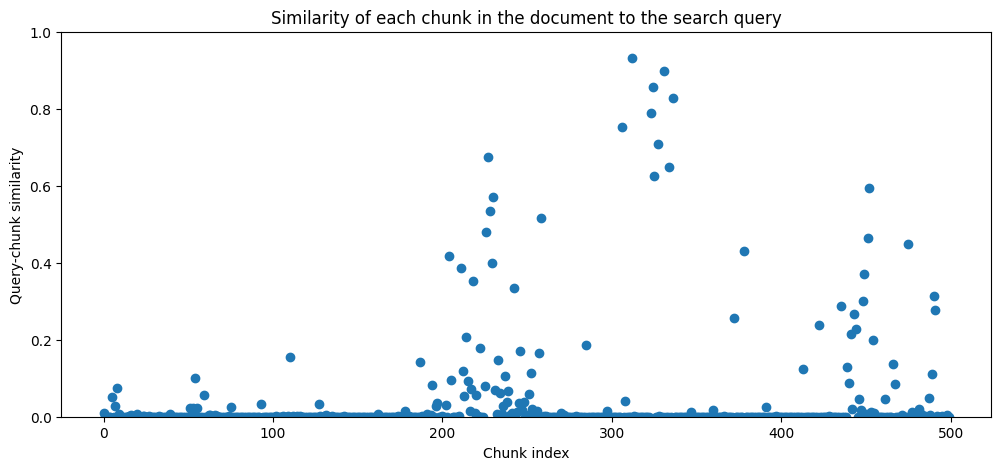

In [11]:
plot_relevance_scores(chunk_values)

### How to interpret the chunk relevance plot above
In the plot above, the x-axis represents the chunk index. The first chunk in the document has index 0, the next chunk has index 1, etc. The y-axis represents the relevance of each chunk to the query. Viewing it this way lets us see how relevant chunks tend to be clustered in one or more sections of a document. 

Note: the relevance values in this plot are actually a combination of the raw relevance value and the relevance ranks. An exponential decay function is applied to the ranks, and that is then multiplied by the raw relevance value. Using this combination provides a more robust measure of relevance than using just one or the other.

### Zooming in
Now let's zoom in on that cluster of relevant chunks for a closer look.

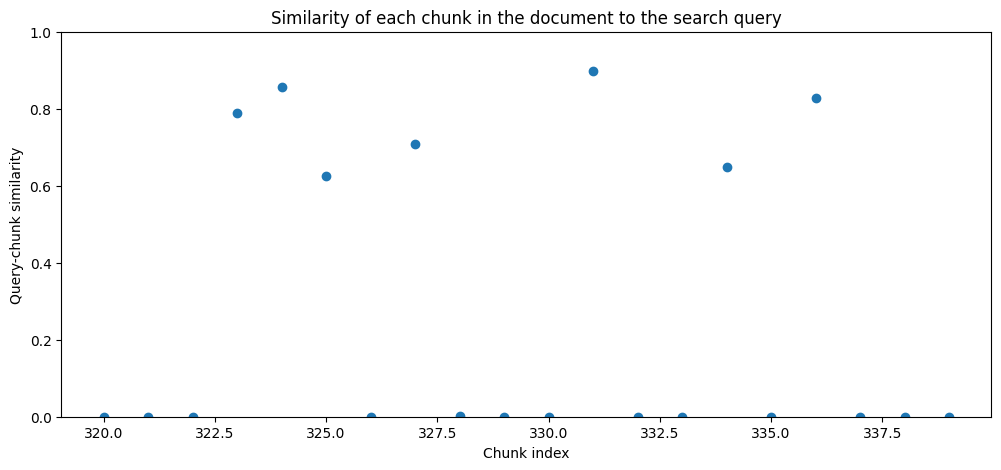

In [12]:
plot_relevance_scores(chunk_values, 320, 340)

What's interesting to note here is that only 7 of these 20 chunks have been marked as relevant by our reranker. And many of the non-relevant chunks are sandwiched between relevant chunks. Looking at the span of 323-336, exactly half of those chunks are marked as relevant and the other half are marked as not relevant.

### Let's see what this part of the document contains

In [13]:
def print_document_segment(chunks: List[str], start_index: int, end_index: int):
    """
    Print the text content of a segment of the document

    Args:
        chunks (list): List of text chunks
        start_index (int): Start index of the segment
        end_index (int): End index of the segment (not inclusive)

    Returns:
        None

    Prints:
        The text content of the specified segment of the document
    """
    for i in range(start_index, end_index):
        print(f"\nChunk {i}")
        print(chunks[i])

print_document_segment(chunks, 320, 340)


Chunk 320
financial statements, taken as a whole, and we are not, by communicating the critical audit matter below , providing a separate 
opinion on the critical audit matter or on the accounts or disclosures to which it relates.
Accounting for Income Taxes
As described in Notes 1 and 7 to the consolidated financial statements, the Company recorded income tax expense of $1,131 
million for the year ended May 31, 2023, and has net deferred tax assets of $1,799 million, including a valuation allowance of $22 
million, and total gross unrecognized tax benefits, excluding related interest and penalties, of $936 million as of May 31, 2023, 
$651 million of which would affect the Company's effective tax rate if recognized in future periods. The realization of deferred tax

Chunk 321
assets is dependent on future taxable earnings. Management assesses the scheduled reversal of deferred tax liabilities, 
projected future taxable income and available tax planning strategies and considers forei

We can see that the Consolidated Statement of Income starts in chunk 323, and everything up to chunk 333 contains consolidated financial statements, which is what we're looking for. So every chunk in that range is indeed relevant and necessary for our query, yet only about half of those chunks were marked as relevant by the reranker. So in addition to providing more complete context to the LLM, by combining these clusters of relevant chunks we actually find important chunks that otherwise would have been ignored.

### What can we do with these clusters of relevant chunks?
The core idea is that clusters of relevant chunks, in their original contiguous form, provide much better context to the LLM than individual chunks can. Now for the hard part: how do we actually identify these clusters?

If we can calculate chunk values in such a way that the value of a segment is just the sum of the values of its constituent chunks, then finding the optimal segment is a version of the maximum subarray problem, for which a solution can be found relatively easily. How do we define chunk values in such a way? We'll start with the idea that highly relevant chunks are good, and irrelevant chunks are bad. We already have a good measure of chunk relevance, on a scale of 0-1, so all we need to do is subtract a constant threshold value from it. This will turn the chunk value of irrelevant chunks to a negative number, while keeping the values of relevant chunks positive. We call this the `irrelevant_chunk_penalty`. A value around 0.2 seems to work well empirically.

In [14]:
def get_best_segments(relevance_values: list, max_length: int, overall_max_length: int, minimum_value: float):
    """
    This function takes the chunk relevance values and then runs an optimization algorithm to find the best segments. In more technical terms, it solves a constrained version of the maximum sum subarray problem.

    Note: this is a simplified implementation intended for demonstration purposes. A more sophisticated implementation would be needed for production use and is available in the dsRAG library.

    Args:
        relevance_values (list): a list of relevance values for each chunk of a document
        max_length (int): the maximum length of a single segment (measured in number of chunks)
        overall_max_length (int): the maximum length of all segments (measured in number of chunks)
        minimum_value (float): the minimum value that a segment must have to be considered

    Returns:
        best_segments (list): a list of tuples (start, end) that represent the indices of the best segments (the end index is non-inclusive) in the document
        scores (list): a list of the scores for each of the best segments
    """
    best_segments = []
    scores = []
    total_length = 0
    while total_length < overall_max_length:
        # find the best remaining segment
        best_segment = None
        best_value = -1000
        for start in range(len(relevance_values)):
            # skip over negative value starting points
            if relevance_values[start] < 0:
                continue
            for end in range(start+1, min(start+max_length+1, len(relevance_values)+1)):
                # skip over negative value ending points
                if relevance_values[end-1] < 0:
                    continue
                # check if this segment overlaps with any of the best segments and skip if it does
                if any(start < seg_end and end > seg_start for seg_start, seg_end in best_segments):
                    continue
                # check if this segment would push us over the overall max length and skip if it would
                if total_length + end - start > overall_max_length:
                    continue
                
                # define segment value as the sum of the relevance values of its chunks
                segment_value = sum(relevance_values[start:end])
                if segment_value > best_value:
                    best_value = segment_value
                    best_segment = (start, end)
        
        # if we didn't find a valid segment then we're done
        if best_segment is None or best_value < minimum_value:
            break

        # otherwise, add the segment to the list of best segments
        best_segments.append(best_segment)
        scores.append(best_value)
        total_length += best_segment[1] - best_segment[0]
    
    return best_segments, scores

In [15]:
# define some parameters and constraints for the optimization
irrelevant_chunk_penalty = 0.2 # empirically, something around 0.2 works well; lower values bias towards longer segments
max_length = 20
overall_max_length = 30
minimum_value = 0.7

# subtract constant threshold value from chunk relevance values
relevance_values = [v - irrelevant_chunk_penalty for v in chunk_values] 

# run the optimization
best_segments, scores = get_best_segments(relevance_values, max_length, overall_max_length, minimum_value)

# print results
print ("Best segment indices")
print (best_segments) # indices of the best segments, with the end index non-inclusive
print ()
print ("Best segment scores")
print (scores)
print ()

Best segment indices
[(323, 337), (226, 231), (448, 453), (312, 313)]

Best segment scores
[2.5559905778741827, 1.6569259433941705, 0.7325434206345869, 0.7318070628222588]



The first segment given by the optimization algorithm is chunks 323-336. Looking at the chunks manually, we decided that 323-333 was the ideal segment, so we got a few bonus chunks that we don't really need, but overall this is going to be a great piece of context for the LLM to work with. We also identified some shorter segments from other parts of the document that we could provide to the LLM as well.

### What if the answer is contained in a single chunk?
In the case where only a single chunk, or a few isolated chunks, are relevant to the query, we don't want to create large segments out of them. We just want to return those specific chunks. RSE can handle that scenario well too. Since there are no clusters of relevant chunks, it basically reduces to standard top-k retrieval in that case. We'll leave it as an exercise to the reader to see what happens to the chunk relevance plot and the resulting best segments for queries like this.

# Eval results

### KITE
We evaluated RSE on an end-to-end RAG benchmark we created, called [KITE](https://github.com/D-Star-AI/KITE) (Knowledge-Intensive Task Evaluation).

KITE currently consists of 4 datasets and a total of 50 questions.
- **AI Papers** - ~100 academic papers about AI and RAG, downloaded from arXiv in PDF form.
- **BVP Cloud 10-Ks** - 10-Ks for all companies in the Bessemer Cloud Index (~70 of them), in PDF form.
- **Sourcegraph Company Handbook** - ~800 markdown files, with their original directory structure, downloaded from Sourcegraph's publicly accessible company handbook GitHub [page](https://github.com/sourcegraph/handbook/tree/main/content).
- **Supreme Court Opinions** - All Supreme Court opinions from Term Year 2022 (delivered from January '23 to June '23), downloaded from the official Supreme Court [website](https://www.supremecourt.gov/opinions/slipopinion/22) in PDF form.

Ground truth answers are included with each sample. Most samples also include grading rubrics. Grading is done on a scale of 0-10 for each question, with a strong LLM doing the grading.

We compare RSE with standard Top-k retrieval (k=20). All other parameters remain the same between the two configurations. We use the Cohere 3 reranker, and we use GPT-4o for response generation. The average length of the relevant knowledge string is roughly the same between the two configurations, so cost and latency are similar.

|                         | Top-k    | RSE    |
|-------------------------|----------|--------|
| AI Papers               | 4.5      | 7.9    |
| BVP Cloud               | 2.6      | 4.4    |
| Sourcegraph             | 5.7      | 6.6    |
| Supreme Court Opinions  | 6.1      | 8.0    |
| **Average**             | 4.72     | 6.73   |

We can see that RSE leads to an improvement in performance on each of the four datasets. The overall average score increases from 4.72 -> 6.73, a 42.6% increase.

### FinanceBench
We've also evaluated RSE on FinanceBench, where it contributed to a score of 83%, compared to a baseline score of 19%. For that benchmark, we tested contextual chunk headers (CCH) and RSE jointly, so we can't say exactly how much RSE contributed to that result. But the combination of CCH and RSE clearly leads to substantial accuracy improvements on FinanceBench.